# MTA Turnstile Analysis

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, datetime
from itertools import product
import pickle

from sqlalchemy import create_engine

## Download Turnstile Data and Store in CSV

In [ ]:
def get_data(url_dates):
    """
    Accept list of dates and return single dataframe with corresponding turnstile data.
    """
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    dfs = []
    for date in url_dates:
        file_url = url.format(date)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs) 

In [ ]:
# Establish start and end date for download. Get all Saturdays in the range in a list.
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 5, 15)
date_list = pd.date_range(start=start_date - timedelta(days=1), end=end_date, freq='W-SAT').tolist()

# Generate list of dates for use in csv downloads.
url_dates = []
for date in date_list:
    year = str(date.year)[-2:]
    month = str(date.month).zfill(2) # zfill method found on StackOverflow
    day = str(date.day).zfill(2)
    
    url_dates.append(year + month + day)

In [ ]:
# Get turnstile data
turnstiles_df = get_data(url_dates)

In [ ]:
# Rename columns and reset index
turnstiles_df.columns = ['ca', 'unit', 'scp', 'station', 'linename', 'division', 'date', 'time', 'desc',
                         'cumulative_entries', 'cumulative_exits']

In [ ]:
turnstiles_df.to_csv('mta_data_sqlite', header=False, index=False)

SQL to Create Table:

```sql
CREATE TABLE mta_data (
ca TEXT,
unit TEXT,
scp TEXT,
station TEXT,
linename TEXT,
division TEXT,
date TEXT,
time TEXT,
desc TEXT,
cumulative_entries INTEGER,
cumulative_exits INTEGER,
PRIMARY KEY (ca, unit, scp, station, linename, division, date, time, desc, cumulative_entries, cumulative_exits)
)
```

## Extract Data from SQLite Database and Inspect

In [2]:
engine = create_engine('sqlite:///mta.db')

In [3]:
# Number of turnstiles by station
station_turnstile_count = pd.read_sql('''SELECT station, COUNT(*) AS turnstiles
                                         FROM (select distinct station, ca, unit, scp 
                                         FROM mta_data
                                         GROUP BY station, ca, unit, scp)
                                         GROUP BY station
                                         ORDER BY turnstiles DESC;''', engine)

station_turnstile_count.head(10)

,station,turnstiles
0,34 ST-PENN STA,111
1,FULTON ST,96
2,GRD CNTRL-42 ST,89
3,23 ST,88
4,86 ST,65
5,CANAL ST,58
6,59 ST,56
7,CHAMBERS ST,55
8,34 ST-HERALD SQ,55
9,ATL AV-BARCLAY,52


In [4]:
# Get data for use in turnstile analysis
filtered_data = pd.read_sql('''SELECT station, ca, unit, scp, date, time, desc, cumulative_entries, cumulative_exits
                               FROM mta_data
                               WHERE cumulative_entries NOT NULL and cumulative_exits NOT NULL
                               ORDER BY station, ca, unit, scp, date, time;''', engine)

In [5]:
filtered_data.head()

,station,ca,unit,scp,date,time,desc,cumulative_entries,cumulative_exits
0,1 AV,H007,R248,00-00-00,01/01/2021,03:00:00,REGULAR,15512487,17566757
1,1 AV,H007,R248,00-00-00,01/01/2021,07:00:00,REGULAR,15512489,17566802
2,1 AV,H007,R248,00-00-00,01/01/2021,11:00:00,REGULAR,15512503,17566903
3,1 AV,H007,R248,00-00-00,01/01/2021,15:00:00,REGULAR,15512538,17567059
4,1 AV,H007,R248,00-00-00,01/01/2021,19:00:00,REGULAR,15512578,17567190


In [6]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4184441 entries, 0 to 4184440
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   station             object
 1   ca                  object
 2   unit                object
 3   scp                 object
 4   date                object
 5   time                object
 6   desc                object
 7   cumulative_entries  int64 
 8   cumulative_exits    int64 
dtypes: int64(2), object(7)
memory usage: 287.3+ MB


In [7]:
filtered_data.describe().style.format('{:0.1f}')

,cumulative_entries,cumulative_exits
count,4184441.0,4184441.0
mean,42130056.4,33901779.6
std,218704298.8,194351661.9
min,0.0,0.0
25%,223549.0,93921.0
50%,1498045.0,900505.0
75%,6164568.0,4053495.0
max,2147432317.0,2123073344.0


#### Key Inspection Takeaways:

The key findings from inspecting the initial data are the the entry and exit data are cumulative and that we will need to convert the date columns (date, time) to a datetime column. In playing with the data (not presented here), it is also clear that the audit scheduling is not necessarily consistent. I will need to standardize the timing of the data in order to present it clearly. Finally, there are some clear errors in the entries and exits columns. Cumulative exits and entries do not always move in forward order, and there is duplicate data that will impact aggregation. This will all need to be addressed in data cleaning 

## Initial Data Cleaining

For initial cleaning, we need to fix a few key issues:
- Reversed Counters - Some turnstiles are set up incorrectly and began counting in reverse, as can be seen by cumulative entry and exit data reversing over time.
- Reset Counters - In some cases, a turnstile's cumulative count will make a large jump, generally downward, as the counter is reset. This leads to inaccurate calculations when looking for daily/hourly entries and exits.
- Large Numbers - The data has certain records that are simply inaccurate, as shown by wildly large entry and exit data relative to the normal level for a given turnstile.

## Convert Data from Cumulative Data to Hourly and Daily Data

Note that I am prepping hourly data (filtered_data, hourly_data) and daily data (month_end_data) simultaneously. These began with separate SQL queries and require slightly different manipulation.

In [20]:
def round_to_hour(df):
    """
    Accept a dataframe with the time column from the MTA db. Add a datetime column rounded to the nearest hour.
    """

    # Create datetime column, rounded to nearest hour
    df[['hour','minute','second']] = df['time'].str.split(':', expand=True)
    df['hour'] = df['hour'].astype(int)
    df['minute'] = df['minute'].astype(int)
    df['second'] = df['second'].astype(int)

    df['hour'] = np.where(df['minute'] >= 30, df['hour'] + 1, df['hour'])
    df['hour'] = df['hour'].astype(str)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' +
                                    np.where(df['hour'] == '24', pd.Series(['00']).repeat(len(df)), 
                                             df['hour']) + ':00:00')

    # When the hour is rounded to 24, the date should be shifted forward by one day
    df['datetime'] = np.where(df['hour'] == '24', df['datetime'] + timedelta(days=1), 
                              df['datetime'])
    
    df.drop(columns=['hour', 'minute', 'second'], inplace=True)
    

In [21]:
# Add datetime column to each dataframe, rounded to the nearest hour.
round_to_hour(filtered_data)

In [22]:
# Create identifier columns for use in group by and for filtering out duplicate audits
filtered_data['identifier'] = filtered_data['station'] + '_' + filtered_data['ca'] + '_' + filtered_data['unit'] + '_' + filtered_data['scp']
filtered_data['identifier_with_datetime'] = filtered_data['identifier'] + '_' + filtered_data['datetime'].astype(str)

In [23]:
# Filter out REGULAR record where a RECOVR AUD record exists at the same time
mask = (filtered_data['identifier_with_datetime'] ==  filtered_data['identifier_with_datetime'].shift(1)) &\
       (filtered_data['desc'] == 'REGULAR') & (filtered_data['desc'].shift(1) == 'RECOVR AUD')

filtered_data = filtered_data[mask != True]

# Keep the first instance of identifier_with_datetime
filtered_data = filtered_data.drop_duplicates(subset='identifier_with_datetime', keep='first')

In [ ]:
# Pickle the filtered_data
with open('pickle_filtered_data.pickle', 'wb') as to_write:
    pickle.dump(filtered_data, to_write)

In [ ]:
# Open pickled filtered_data
with open('pickle_filtered_data.pickle', 'rb') as read_file:
    filtered_data = pickle.load(read_file)

#### Initial Data Cleaining

For initial cleaning, we need to fix a few key issues:
- Reversed Counters - Some turnstiles are set up incorrectly and began counting in reverse, as can be seen by cumulative entry and exit data reversing over time.
- Reset Counters - In some cases, a turnstile's cumulative count will make a large jump, generally downward, as the counter is reset. This leads to inaccurate calculations when looking for daily/hourly entries and exits.
- Large Numbers - The data has certain records that are simply inaccurate, as show be wildly large entry and exit data relative to the normal level for a given turnstile.

In [24]:
filtered_data['prev_entries'] = (filtered_data.groupby('identifier')[['cumulative_entries']]
                                              .shift(1))

filtered_data['prev_exits'] = (filtered_data.groupby('identifier')[['cumulative_exits']]
                                            .shift(1))

In [25]:
filtered_data.head()

,station,ca,unit,scp,date,time,desc,cumulative_entries,cumulative_exits,datetime,identifier,identifier_with_datetime,prev_entries,prev_exits
0,1 AV,H007,R248,00-00-00,01/01/2021,03:00:00,REGULAR,15512487,17566757,2021-01-01 03:00:00,1 AV_H007_R248_00-00-00,1 AV_H007_R248_00-00-00_2021-01-01 03:00:00,NaN,NaN
1,1 AV,H007,R248,00-00-00,01/01/2021,07:00:00,REGULAR,15512489,17566802,2021-01-01 07:00:00,1 AV_H007_R248_00-00-00,1 AV_H007_R248_00-00-00_2021-01-01 07:00:00,15512487.0,17566757.0
2,1 AV,H007,R248,00-00-00,01/01/2021,11:00:00,REGULAR,15512503,17566903,2021-01-01 11:00:00,1 AV_H007_R248_00-00-00,1 AV_H007_R248_00-00-00_2021-01-01 11:00:00,15512489.0,17566802.0
3,1 AV,H007,R248,00-00-00,01/01/2021,15:00:00,REGULAR,15512538,17567059,2021-01-01 15:00:00,1 AV_H007_R248_00-00-00,1 AV_H007_R248_00-00-00_2021-01-01 15:00:00,15512503.0,17566903.0
4,1 AV,H007,R248,00-00-00,01/01/2021,19:00:00,REGULAR,15512578,17567190,2021-01-01 19:00:00,1 AV_H007_R248_00-00-00,1 AV_H007_R248_00-00-00_2021-01-01 19:00:00,15512538.0,17567059.0


In [26]:
def get_periodic_counts(row, max_counter, metric):
    counter = row['cumulative_' + metric] - row['prev_' + metric]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        counter = min(row['cumulative_' + metric], row['prev_' + metric])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0

    return counter

In [27]:
# Calculate per hour entries and exits and hours between audits (hour span)
filtered_data['entries'] = filtered_data.apply(get_periodic_counts, axis=1, max_counter=259200, metric='entries')
filtered_data['exits'] = filtered_data.apply(get_periodic_counts, axis=1, max_counter=259200, metric='exits')
filtered_data['hour_span'] = filtered_data.groupby(['identifier'])[['datetime']].diff(1).astype('timedelta64[h]')

In [28]:
# Convert cumulative data to per period (hour, day) entries and exits
filtered_data['entries_per_hour'] = filtered_data['entries'] / filtered_data['hour_span']
filtered_data['exits_per_hour'] = filtered_data['exits'] / filtered_data['hour_span']

In [ ]:
# Create new dataframe with all identifier and hour combinations in the relevant date range (hourly_data only)
identifiers = filtered_data['identifier'].unique()
max_date = filtered_data['datetime'].max().date()
min_date = filtered_data['datetime'].min().date()
datetimes = pd.date_range(start=min_date, end=max_date, freq='H').tolist()    

all_identifiers = []
all_datetimes = []
all_identifiers_with_datetime = []

for i, d in product(identifiers, datetimes):
    all_identifiers.extend([i])
    all_datetimes.extend([d])
    all_identifiers_with_datetime.extend([i + '_' + str(d)])

hourly_dict = {'identifier' : all_identifiers,
               'datetime' : all_datetimes,
               'identifier_with_datetime' : all_identifiers_with_datetime
              }
hourly_data = pd.DataFrame(hourly_dict)

In [ ]:
# Split identifier to separate columns (hourly_data_only)
hourly_data[['station', 'ca', 'unit','scp']] = hourly_data['identifier'].str.split('_', expand=True)

# Merge filtered_data df to the hourly_data df and backfill nan values for hours without matches
merge_cols = ['identifier_with_datetime', 'hour_span', 'entries_per_hour', 'exits_per_hour']
hourly_data = hourly_data.merge(filtered_data[merge_cols], how='left', on='identifier_with_datetime')
hourly_data.fillna(method='bfill', inplace=True) # backfill functionality found on StackOverflow

In [ ]:
hourly_data.describe()

In [ ]:
# Pickle the hourly_data
with open('pickle_hourly_data.pickle', 'wb') as to_write:
    pickle.dump(hourly_data, to_write)

In [8]:
# Open pickled hourly_data
with open('pickle_hourly_data.pickle', 'rb') as read_file:
    hourly_data = pickle.load(read_file)

## Explore and Remove Erroneous Data

In [9]:
# Remove any lines with negative entries/exits/period span, as the data is unusable
hourly_data = hourly_data[(hourly_data['entries_per_hour'] >= 0) & 
                          (hourly_data['exits_per_hour'] >= 0) & 
                          (hourly_data['hour_span'] >= 0)]

In [10]:
def plot_hist(entries, exits, title, color):
    fig, axes = plt.subplots(2, 2, figsize=[16, 8])
    fig.tight_layout(pad=3.0)
    fig.subplots_adjust(top=0.9)
    fig.suptitle(title, fontsize=16)

    plt.subplot(2,2,1) # (number of rows, number of columns, number of plot)
    plt.hist(entries, bins=50, color=color)
    plt.title('Entries per Period')
    plt.subplot(2,2,3)
    plt.hist(entries, bins=50, color=color)
    x1,x2,y1,y2 = plt.axis()  
    plt.axis((x1,x2,0,100)) # zoom in on y-axis 0-100

    plt.subplot(2,2,2)
    plt.hist(exits, bins=50, color=color)
    plt.title('Exits per Period')
    plt.subplot(2,2,4)
    plt.hist(exits, bins=50, color=color)
    x1,x2,y1,y2 = plt.axis()  
    plt.axis((x1,x2,0,100)) # zoom in on y-axis 0-100

    plt.show();

#### Hourly Data Additional Cleaning

The most individuals I can imagine moving through a turnstile in a single one hour period is around 7,200. Say 2 people make it through a turnstile every single second for the entire hour. This would translate to 7,200 people in that hour (2 per second x 60 seconds per minute x 60 minutes per hour). It is possible, in certain hours, that the entire 7,200 people are entering the station or exiting the station. Perhaps there is a massive sporting event or social gathering of some kind. Let's see what the distribution of hourly entires and exits would like like with and without this 7,200 person cutoff.

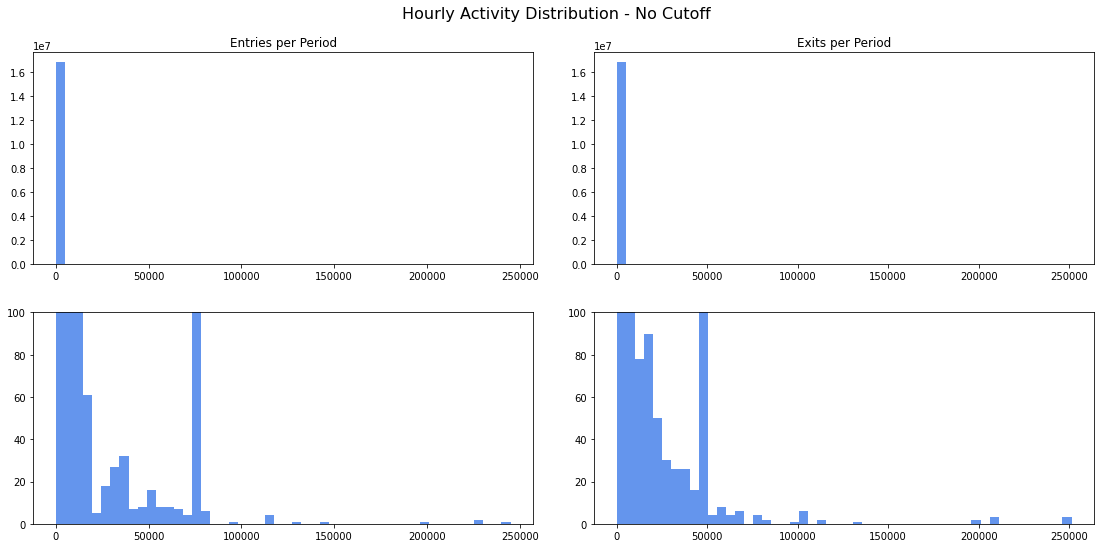

In [11]:
plot_hist(hourly_data['entries_per_hour'], hourly_data['exits_per_hour'], 'Hourly Activity Distribution - No Cutoff', 'cornflowerblue')

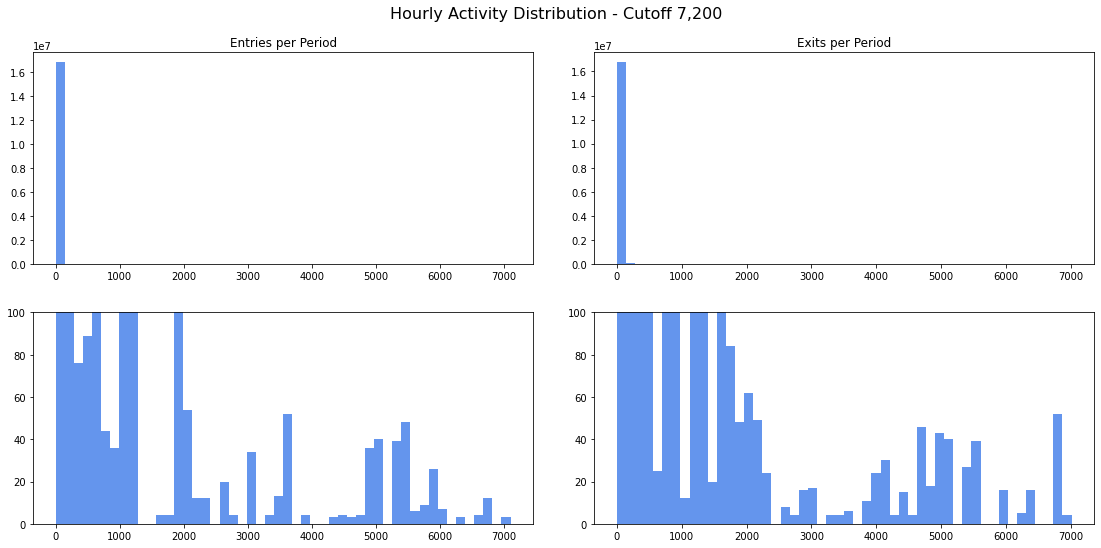

In [12]:
hourly_data = hourly_data[(hourly_data['entries_per_hour'] < 7200) & (hourly_data['exits_per_hour'] < 7200)]
plot_hist(hourly_data['entries_per_hour'], hourly_data['exits_per_hour'], 'Hourly Activity Distribution - Cutoff 7,200', 'cornflowerblue')

Even this cutoff doesn't quite seem appropriate. Ultimately, the goal is to produce a usable tool for customers that shows average traffic over a prior time period. I'd like to cut out some of these outliers so they do not skew the data. To get an idea of what some of the busier turnstiles might look like, I will first find the stations with the most turnstiles, which should be an indicators that they are used more frequently. I'd like to examine the boxplot distribution for the top 5 stations for average hourly entries. 

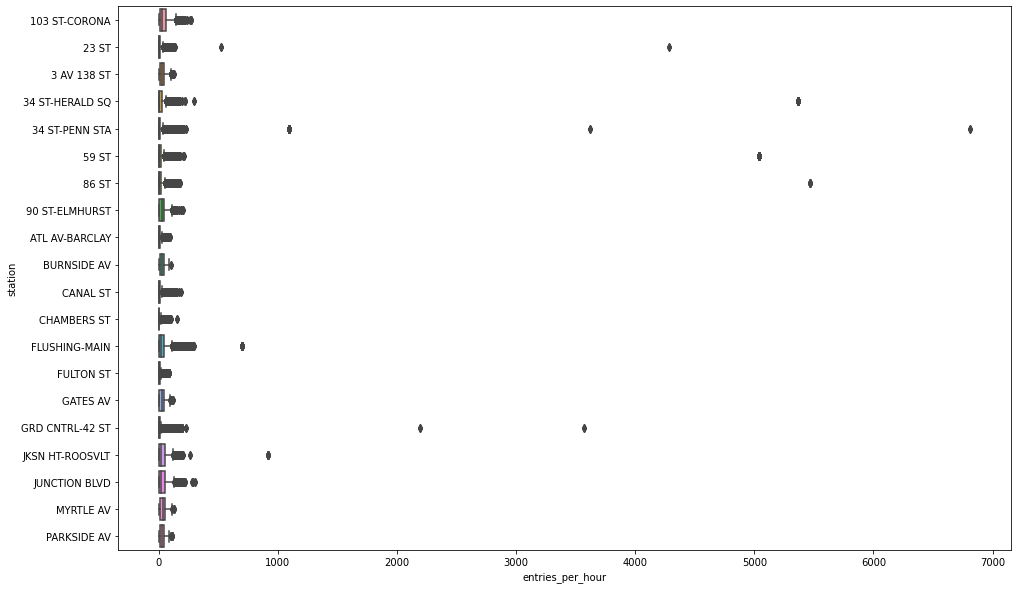

In [13]:
top_10_by_entries = hourly_data.groupby('station').mean(['entries_per_hour', 'exits_per_hour']).sort_values('entries_per_hour', ascending=False).head(10)
top_10_by_turnstiles = hourly_data[['station', 'identifier']].groupby('station').nunique().sort_values('identifier', ascending=False).head(10)
top_stations = set(list(top_10_by_entries.index) + list(top_10_by_turnstiles.index))

box_data = hourly_data[hourly_data['station'].isin(top_stations)]

fig = plt.figure(figsize=[16,10])
sns.boxplot(x='entries_per_hour', y='station', data=box_data);

Based on the above boxplot of the top stations by turnstiles and by average entries per hour, it makes sense to cut off the hourly entries at 500. Let's make that cutoff and replot the histogram and the boxplots.

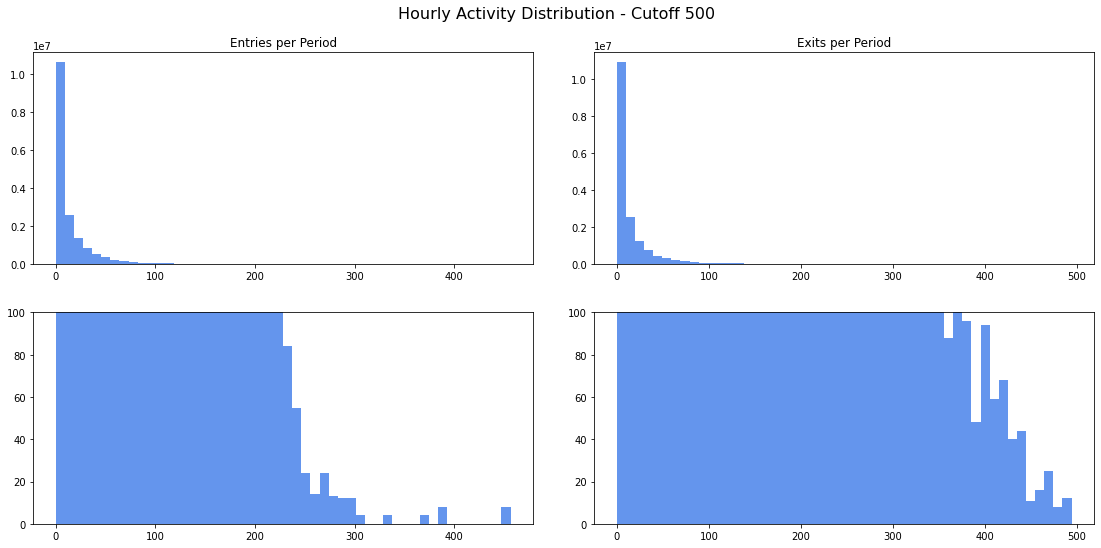

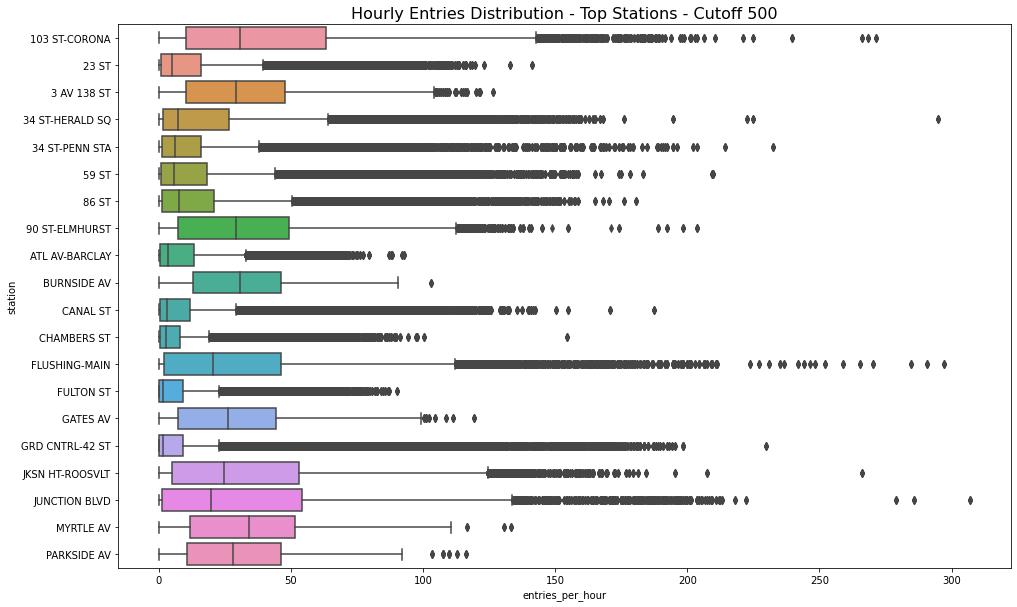

In [14]:
hourly_data = hourly_data[(hourly_data['entries_per_hour'] < 500) & (hourly_data['exits_per_hour'] < 500)]
plot_hist(hourly_data['entries_per_hour'], hourly_data['exits_per_hour'], 'Hourly Activity Distribution - Cutoff 500', 'cornflowerblue')

box_data = hourly_data[hourly_data['station'].isin(top_stations)]

fig = plt.figure(figsize=[16,10])
sns.boxplot(x='entries_per_hour', y='station', data=box_data).set_title('Hourly Entries Distribution - Top Stations - Cutoff 500', fontsize=16);

There are still many many outliers, but they should be taken with a grain of salt. Our data skews heavily towared zero entries on an hourly basis, because there are many times when the subways are being used very little, such as on weekdays in the very early morning. In addition, these hourly totals for entries and exits are well within the realm of true possibilities. In normal times unaffected by COVID, the average entries and exits would be significantly higher. I will move forward with these cutoffs. 

## Create Daily Data from Hourly Data

In [ ]:
hourly_data.head()

In [ ]:
daily_data = hourly_data.copy()
daily_data['date'] = daily_data['datetime'].dt.date
daily_data = daily_data.groupby(['station', 'date']).sum().reset_index()
daily_data['month'] = pd.DatetimeIndex(daily_data['date']).month
daily_data.rename(columns={'entries_per_hour' : 'entries_per_day',
                           'exits_per_hour' : 'exits_per_day'}, inplace=True)
daily_data.drop(columns='hour_span', inplace=True)

In [ ]:
daily_data.head()

In [ ]:
# Pickle the daily_data
with open('pickle_daily_data.pickle', 'wb') as to_write:
    pickle.dump(daily_data, to_write)

In [15]:
# Open pickled hourly_data and daily_data
with open('pickle_hourly_data.pickle', 'rb') as read_file:
    hourly_data = pickle.load(read_file)

with open('pickle_daily_data.pickle', 'rb') as read_file:
    daily_data = pickle.load(read_file)

#### Daily Data Additional Cleaning

I'll now move on to the scrubbing daily averages, built from the cleaned hourly data. Since I scrubbed the hourly data, I may not need to add any additional cutoffs to the daily data, as long as the distribution is reasonable.

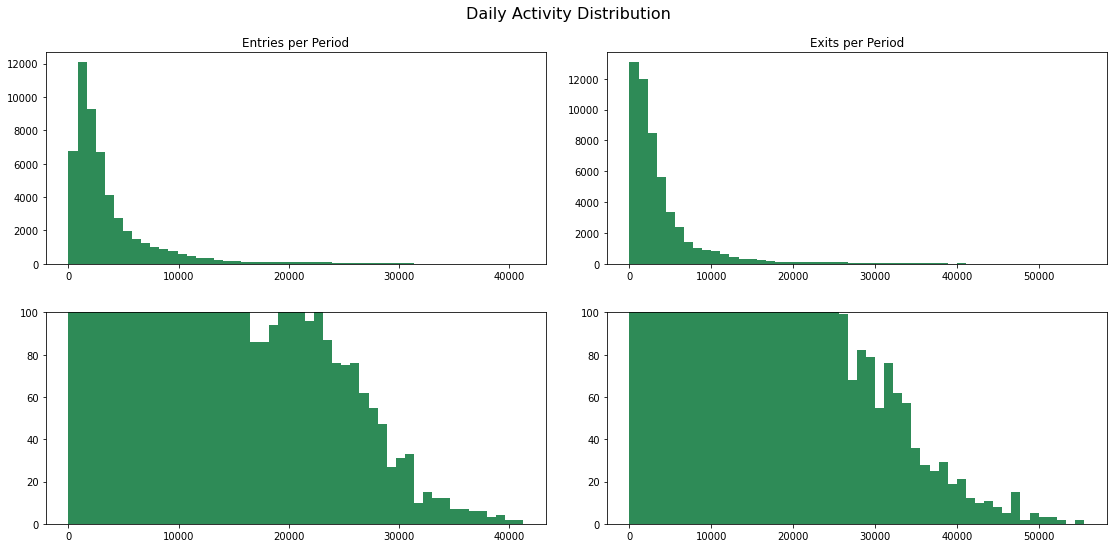

In [16]:
plot_hist(daily_data['entries_per_day'], daily_data['exits_per_day'], 'Daily Activity Distribution', 'seagreen')

This appears fairly reasonable. The daily entries peaks around 40,000, which equates to around one person every two seconds. Exits peak around 55,000. On particularly busy days in the heart of NYC, this seems plausible. I will do no further parsing of the data.

Next, I'd like to quickly check the standard statistics for my hourly and daily populations after the data cleaning.

#### Final Inspection

In [17]:
# Build combined describe table for hourly and daily data
hourly_desc = hourly_data.describe()
daily_desc = daily_data[['entries_per_day', 'exits_per_day']].describe()

hourly_desc.merge(daily_desc, how='left', left_index=True, right_index=True).style.format('{:0.1f}')

,hour_span,entries_per_hour,exits_per_hour,entries_per_day,exits_per_day
count,16993213.0,16993213.0,16993213.0,52947.0,52947.0
mean,-29.9,16.8,17.7,3761.7,4059.8
std,336.3,595.3,437.8,4462.2,5369.9
min,-3360.0,-75.6,-77.1,0.0,0.0
25%,4.0,0.2,0.8,1242.9,1124.4
50%,4.0,4.2,4.8,2320.0,2401.5
75%,4.0,15.8,15.5,4352.6,4625.9
max,1236.0,244982.0,251311.0,41255.2,55497.2


The max of the hour_span is a bit concerning. We shouldn't be seeing audits this 1,236 hours apart, generally. I picked out the turnstiles with the most offending hour_spans (see span_count below). You can see that, for the most part, these turnstile are not contributing significantly to total entries and exits. Newark did contribute significantly, but in checking further, it's clear that there truly was a very long gap between audits. See below, where I have illustrated that there was an audit on 12/31/2020, and then no audit until 4/15/2021. While odd, the data does appear legitimate, and I don't believ it impacts station metrics, as I am aggregating entries and exits by station and ignoring individual turnstiles.

In [18]:
hourly_data[hourly_data['hour_span'] > 48].groupby('identifier')[['hour_span', 'entries_per_hour', 'exits_per_hour']]\
                                          .agg({'hour_span' : 'count', 'entries_per_hour' : 'sum', 'exits_per_hour' : 'sum'})\
                                          .sort_values('hour_span', ascending=False)\
                                          .head(10)\
                                          .rename(columns={'hour_span' : 'span_count', 
                                                           'entries_per_hour' : 'total_entries',
                                                           'exits_per_hour' : 'total_exits'})

,span_count,total_entries,total_exits
identifier,,,
NEWARK HW BMEBE_PTH01_R549_00-01-08,2950,4523.333333,7.095462e+05
PAVONIA/NEWPORT_PTH06_R546_00-00-00,2741,0.000000,2.105135e+06
96 ST-2 AVE_N702_R572_00-05-01,1236,1.000000,4.850000e+02
231 ST_R194_R040_00-03-01,870,0.000000,1.000000e+00
JOURNAL SQUARE_PTH03_R552_00-05-03,861,5.000000,8.200000e+01
DITMAS AV_N547_R420_01-06-00,774,31.000000,4.970000e+02
KINGS HWY_B024_R211_00-05-01,680,0.000000,8.000000e+00
OCEAN PKWY_B034_R264_01-06-00,673,22.000000,3.900000e+01
GRD CNTRL-42 ST_R235_R045_01-00-00,632,3.000000,8.700000e+01


In [29]:
filtered_data[filtered_data['identifier'] == 'NEWARK HW BMEBE_PTH01_R549_00-01-08']\
    .groupby(['identifier', 'datetime'])[['scp']].count().reset_index().head(5).drop(columns=['scp'])

,identifier,datetime
0,NEWARK HW BMEBE_PTH01_R549_00-01-08,2020-12-31 09:00:00
1,NEWARK HW BMEBE_PTH01_R549_00-01-08,2020-12-31 11:00:00
2,NEWARK HW BMEBE_PTH01_R549_00-01-08,2020-12-31 14:00:00
3,NEWARK HW BMEBE_PTH01_R549_00-01-08,2021-04-15 09:00:00
4,NEWARK HW BMEBE_PTH01_R549_00-01-08,2021-05-03 12:00:00


In [30]:
filtered_data[filtered_data['identifier'] == '96 ST-2 AVE_N702_R572_00-05-01']\
    .groupby(['identifier', 'datetime'])[['scp']].count().reset_index().tail(5).drop(columns=['scp'])

,identifier,datetime
527,96 ST-2 AVE_N702_R572_00-05-01,2021-03-23 21:00:00
528,96 ST-2 AVE_N702_R572_00-05-01,2021-03-24 01:00:00
529,96 ST-2 AVE_N702_R572_00-05-01,2021-03-24 05:00:00
530,96 ST-2 AVE_N702_R572_00-05-01,2021-05-14 17:00:00
531,96 ST-2 AVE_N702_R572_00-05-01,2021-05-14 21:00:00


In [ ]:
# Pickle the hourly_data and month_end_data
with open('pickle_hourly_data_v2.pickle', 'wb') as to_write:
    pickle.dump(hourly_data, to_write)

In [31]:
# Open pickled hourly_data and month_end_data
with open('pickle_hourly_data_v2.pickle', 'rb') as read_file:
    hourly_data = pickle.load(read_file)

with open('pickle_daily_data.pickle', 'rb') as read_file:
    daily_data = pickle.load(read_file)

## Prepare Hourly Data for Tableau

In [ ]:
# Drop scp related columns, create station_linename identifier
hourly_data = hourly_data[['station', 'datetime', 'entries_per_hour', 'exits_per_hour']].copy()

In [ ]:
# Subtract one hour from datetime to convert from "hour ending x" to "hour beginning x"
hourly_data['datetime'] = hourly_data['datetime'] - timedelta(hours=1)

# Add time date, and day of week columns for filtering in Tableau
hourly_data['date'] = hourly_data['datetime'].dt.date
hourly_data['time']= hourly_data['datetime'].dt.strftime('%H:%M')
hourly_data['weekday'] = hourly_data['datetime'].dt.day_name()

# Add a net flow column for entries versus exits
hourly_data['net_flow'] = hourly_data['entries_per_hour'] - hourly_data['exits_per_hour']

In [ ]:
# Drop first two of the dataset due to potential erroneous hour span issues
min_date = hourly_data['date'].min() + timedelta(days=1)
hourly_data = hourly_data[hourly_data['date'] > min_date]

In [ ]:
# Perform group by to remove scp totals and instead total by station/linename/datetime combinations
station_time_data = hourly_data.groupby(['station', 'datetime', 'date', 'time', 'weekday']).sum().reset_index()

print('Shape before group by: ', hourly_data.shape)
print('Shape after group by:  ', station_time_data.shape)

In [ ]:
station_time_data['total_traffic'] = station_time_data['entries_per_hour'] + station_time_data['exits_per_hour']

In [ ]:
station_time_data.to_csv('mta_tableau.csv')

## Daily Usage by Month Visualizations

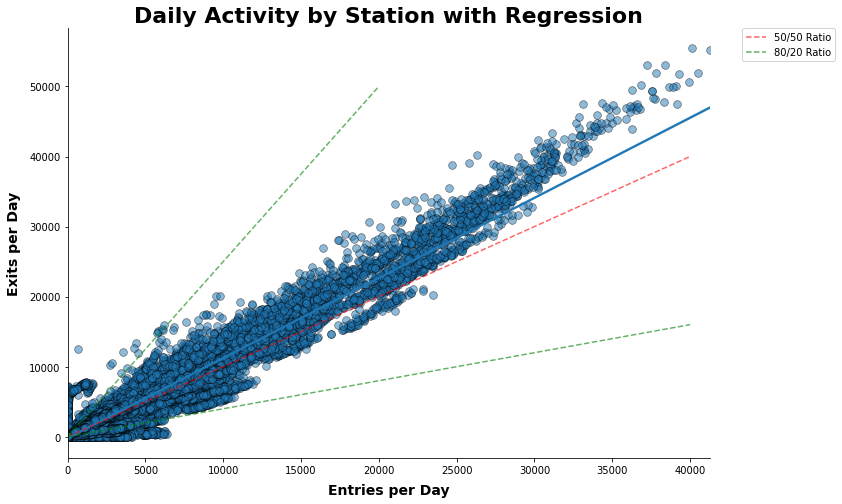

In [32]:
# Scatter with Regression - Entries vs. Exits
sns.lmplot(x='entries_per_day', y='exits_per_day', data=daily_data, height=6.5, aspect=1.5, robust=True,
           scatter_kws=dict(s=60, linewidths=.7, edgecolors='black', alpha=0.5))

sns.lineplot(x=[0,40000], y=[0,40000], color='red', alpha=0.6, linestyle='--', label='50/50 Ratio')
sns.lineplot(x=[0,40000], y=[0,16000], color='green', alpha=0.6, linestyle='--', label='80/20 Ratio')
sns.lineplot(x=[0,20000], y=[0,50000], color='green', alpha=0.6, linestyle='--')

ax = plt.gca()
ax.set_title('Daily Activity by Station with Regression', fontsize=22, fontweight='bold')
ax.set_ylabel('Exits per Day', fontsize=14, fontweight='bold', labelpad=8)
ax.set_xlabel('Entries per Day', fontsize=14, fontweight='bold',labelpad=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # found on StackOverflow

plt.show();

In [33]:
# Entries per Station by Month - Boxplots
station_by_month = daily_data.groupby(['month', 'station'])[['entries_per_day']].median().reset_index()
station_by_month = station_by_month[station_by_month['month'] <= 5]

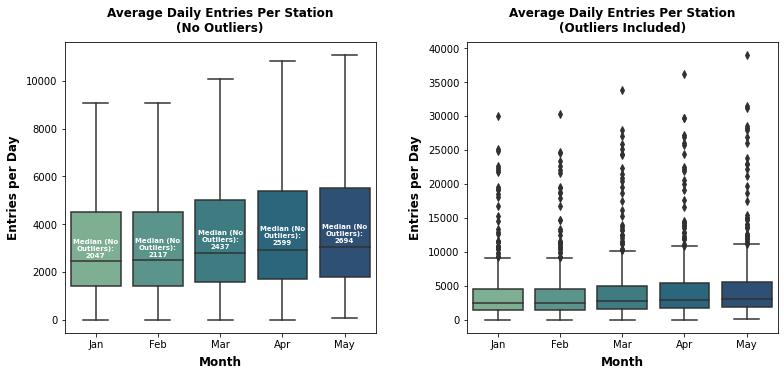

In [34]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May']

fig, axes = plt.subplots(1, 2, figsize=[12, 6])

fig.tight_layout(pad=6)

axes[0].set_title('Average Daily Entries Per Station\n(No Outliers)', fontsize=12, fontweight='bold', pad=10)
sns.boxplot(ax=axes[0], x='month', y='entries_per_day', data=station_by_month, notch=False, showfliers=False, palette='crest')
axes[0].set_ylabel('Entries per Day', fontsize=12, fontweight='bold', labelpad=6)
axes[0].set_xlabel('Month', fontsize=12, fontweight='bold',labelpad=6)
axes[0].set_xticklabels(month_list)

medians = daily_data.groupby(['month'])['entries_per_day'].median().astype(int)
vertical_offset = station_by_month['entries_per_day'].median() * 0.2

for xtick in axes[0].get_xticks():    
    axes[0].text(xtick, medians[xtick + 1] + vertical_offset, 'Median (No\nOutliers):\n' + str(int(medians[xtick + 1])), 
           horizontalalignment='center',size=7,color='w',weight='semibold')

axes[1].set_title('Average Daily Entries Per Station\n(Outliers Included)', fontsize=12, fontweight='bold', pad=10)
sns.boxplot(ax=axes[1], x='month', y='entries_per_day', data=station_by_month, notch=False, showfliers=True, palette='crest')
axes[1].set_ylabel('Entries per Day', fontsize=12, fontweight='bold', labelpad=6)
axes[1].set_xlabel('Month', fontsize=12, fontweight='bold',labelpad=6)
axes[1].set_xticklabels(month_list)

plt.show();

In [35]:
station_first_5_months = station_by_month.groupby('station').mean().sort_values('entries_per_day', ascending=False).reset_index()

In [36]:
station_first_5_months

,station,month,entries_per_day
0,34 ST-PENN STA,3,33856.800000
1,34 ST-HERALD SQ,3,27765.673913
2,86 ST,3,27514.385000
3,125 ST,3,25323.575000
4,GRD CNTRL-42 ST,3,25256.047920
...,...,...,...
373,ROCKAWAY PARK B,3,242.825000
374,BEACH 90 ST,3,231.150000
375,BEACH 98 ST,3,115.475000
376,BROAD CHANNEL,3,102.325000


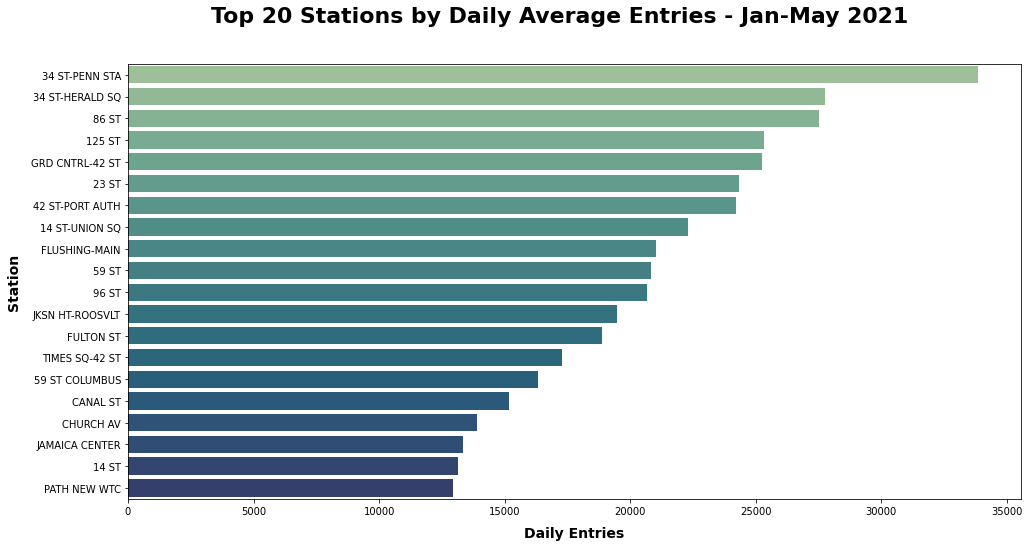

In [37]:
# Top 20 Stations by Daily Entries
fig = plt.figure(figsize=(16,8))

fig.suptitle('Top 20 Stations by Daily Average Entries - Jan-May 2021', fontsize=22, fontweight='bold')

ax = sns.barplot(x='entries_per_day', y='station', data=station_first_5_months.head(20),
            order=station_first_5_months['station'].head(20), palette='crest')

ax.set_ylabel('Station', fontsize=14, fontweight='bold', labelpad=10)
ax.set_xlabel('Daily Entries', fontsize=14, fontweight='bold',labelpad=10)

plt.show()

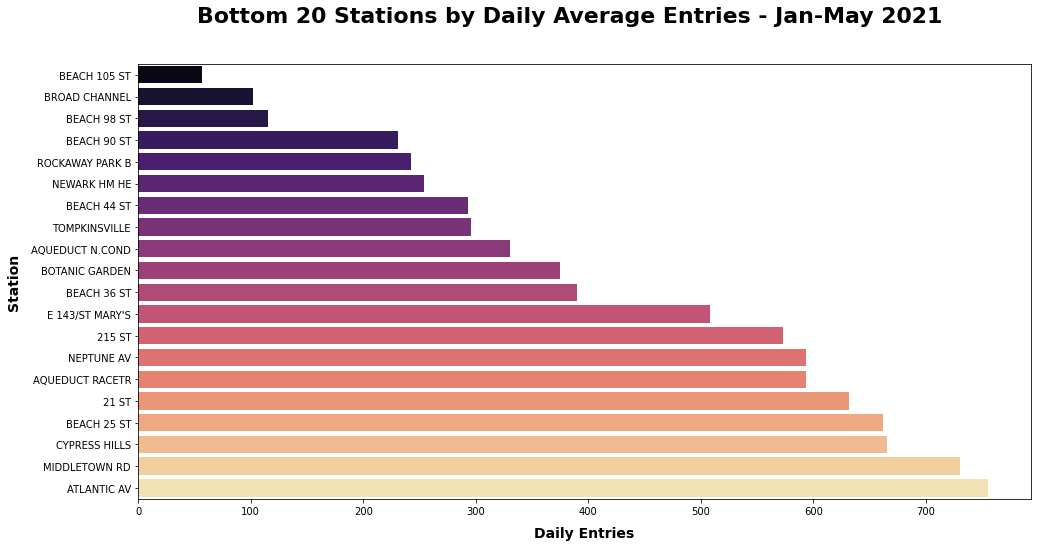

In [38]:
# Bottom 20 Stations by Daily Entries
fig = plt.figure(figsize=(16,8))

fig.suptitle('Bottom 20 Stations by Daily Average Entries - Jan-May 2021', fontsize=22, fontweight='bold')

ax = sns.barplot(x='entries_per_day', y='station', data=station_first_5_months.tail(20)[::-1],
            order=station_first_5_months['station'].tail(20)[::-1], palette='magma')

ax.set_ylabel('Station', fontsize=14, fontweight='bold', labelpad=10)
ax.set_xlabel('Daily Entries', fontsize=14, fontweight='bold',labelpad=10)

plt.show()

In [39]:
station_month_crosstab = station_by_month.pivot(index='station', columns='month')['entries_per_day'].reset_index()

station_month_crosstab = station_month_crosstab[station_month_crosstab[1] > 0]
station_month_crosstab['may_vs_jan'] = station_month_crosstab[5] - station_month_crosstab[1]
station_month_crosstab['may_vs_jan_perc'] = station_month_crosstab[5] / station_month_crosstab[1] - 1

perc_sort = station_month_crosstab.sort_values('may_vs_jan_perc')
abs_sort = station_month_crosstab.sort_values('may_vs_jan')

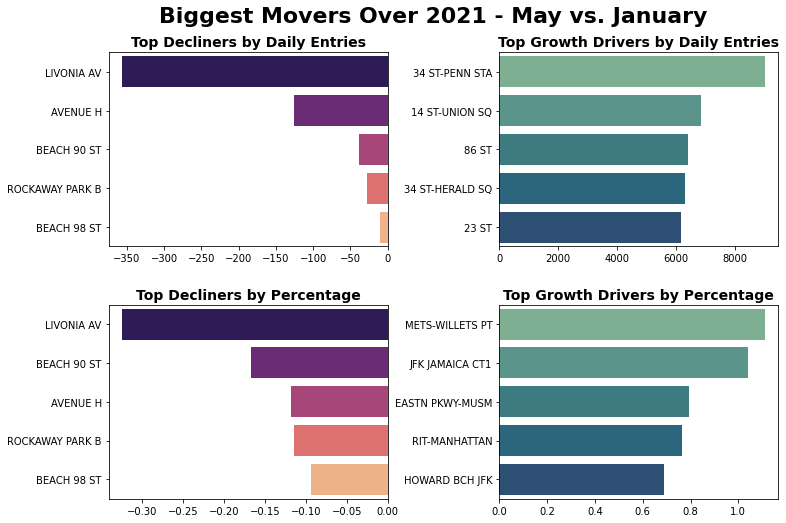

In [40]:
# Biggest Movers (Absolute and %)
fig, axes = plt.subplots(2, 2, figsize=[12, 8])
fig.subplots_adjust(top=0.9, wspace=0.4, hspace=0.3)
fig.suptitle('Biggest Movers Over 2021 - May vs. January', fontsize=22, fontweight='bold')

plt.subplot(2,2,1)
ax = sns.barplot(x='may_vs_jan', y='station', data=abs_sort.head(5),
                 order=abs_sort['station'].head(5), palette='magma')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Top Decliners by Daily Entries', fontsize=14, fontweight='bold')

plt.subplot(2,2,2)
ax = sns.barplot(x='may_vs_jan', y='station', data=abs_sort.tail(5)[::-1],
                 order=abs_sort['station'].tail(5)[::-1], palette='crest')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Top Growth Drivers by Daily Entries', fontsize=14, fontweight='bold')

plt.subplot(2,2,3)
ax = sns.barplot(x='may_vs_jan_perc', y='station', data=perc_sort.head(5),
                 order=perc_sort['station'].head(5), palette='magma')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Top Decliners by Percentage', fontsize=14, fontweight='bold')

plt.subplot(2,2,4)
ax = sns.barplot(x='may_vs_jan_perc', y='station', data=perc_sort.tail(5)[::-1],
                 order=perc_sort['station'].tail(5)[::-1], palette='crest')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Top Growth Drivers by Percentage', fontsize=14, fontweight='bold')

plt.show();